### Step 1: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [203]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq

api_client = Coinpaprika.Client()
market_overview = api_client.global_market_overview()

#print(market_overview)

all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
bnb-binance-coin
xrp-xrp
usdt-tether
ada-cardano
doge-dogecoin
dot-polkadot
ltc-litecoin
bch-bitcoin-cash


## get historical data 

In [204]:
from datetime import datetime, timedelta

coin = 'btc-bitcoin'
color = 'green'

hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=4),
    end=datetime.now()
)
# TODO: "clean up" data (na's, outliers, etc.)

In [205]:
def getNewsAverage(today):
    pytrends = TrendReq()

    kw_list = ["Bitcoin"]

    # get timeframe of last 28 days
    #today = hist[0]['time_open']
    new_date = today - timedelta(days=28)
    toString = today.strftime("%Y-%m-%d")
    fromString = new_date.strftime("%Y-%m-%d")
    timespan = fromString + " " + toString

    pytrends.build_payload(kw_list, cat=0, timeframe=timespan, geo='', gprop='')
    df = pytrends.interest_over_time()

    # calculate average
    average = 0
    for i in range(0, len(df['Bitcoin'])):
        average += df['Bitcoin'][i]
    average /= len(df['Bitcoin'])

    return average
    

In [206]:
alldata = []
for i in range(0,len(hist)):
    # 0: pdctPositive, 1: PDCT predicted difference closing tomorrow, 2: closing, 3: variance, 4: time_open, 5: volume, 6: news
    variance = hist[i]['high'] - hist[i]['low']
    if(i == 0):
        pdct = 0
    else:
        pdct = hist[i]['close'] - hist[i-1]['close']
        
    pdctPositive = pdct > 0
    alldata.append({"pdctPositive": pdctPositive, "pdct": pdct, "close": hist[i]['close'], "variance": variance, "time_open": hist[i]['time_open'], "volume": hist[i]['volume'], "news": getNewsAverage(hist[i]['time_open'])})

In [207]:
hist[0]

{'time_open': datetime.datetime(2021, 4, 2, 0, 0),
 'time_close': datetime.datetime(2021, 4, 2, 23, 59, 59),
 'open': 58771.10234212,
 'high': 60086.03463254,
 'low': 58600.22488015,
 'close': 59035.72783202,
 'volume': 53148416451,
 'market_cap': 1097317485131}

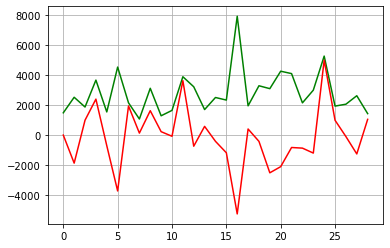

In [219]:
import matplotlib.pyplot as plt

graphdata = []
for i in range(0, len(alldata)):
    graphdata.append(alldata[i]['variance'])
pdct = []
for i in range(0, len(alldata)):
    pdct.append(alldata[i]['pdct'])

plt.plot(graphdata, "green")
plt.plot(pdct, "red")
plt.grid(True)
plt.show()

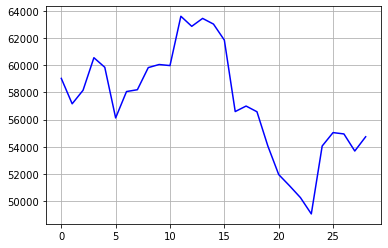

In [220]:
close = []
for i in range(0, len(alldata)):
    close.append(alldata[i]['close'])

plt.plot(close, "blue")
plt.grid(True)
plt.show()

moving average golden cross ()

## Ziel: Klassifikation: Ist der nächste Tick (Tag) höher oder tiefer als heute
> Klassifikationstree

### Daten:
- [x] Close heute
- [x] Varianz heute (high - low)
- [ ] Moving Average (letztes Jahr)
- [x] News Coverage (Google Trends) > pytrends

### Trainingsdatenset:
- von Paprikacoin API

In [199]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import metrics

# CART
numberOfTestData = int(0.2 * len(alldata))

alldata = pd.DataFrame(alldata)

#feature_cols = ['close', 'variance', 'volume', 'news']
feature_cols = ['variance']

X = alldata[feature_cols]              # Features
y = alldata['pdctPositive']            # Target variable

X_train = X[:-numberOfTestData]
X_test  = X[-numberOfTestData:]
y_train = y[:-numberOfTestData]
y_test  = y[-numberOfTestData:]

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred).round(4))

Accuracy: 0.8


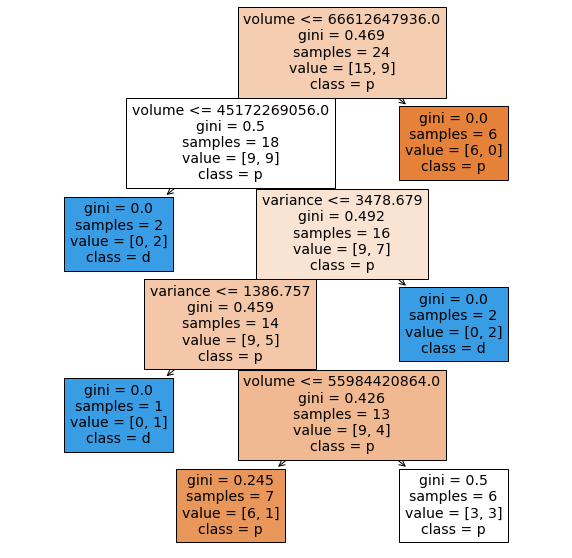

In [197]:

from sklearn import tree

fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(clf, 
                   feature_names=feature_cols,  
                   class_names='pdctPositive',
                   filled=True)